# QuantumSim - Quantum Phase Estimation
Author: Nico Kuijpers<br>
Date: December 31, 2024

Quantum Phase Estimation (QPE) is a common building block applied in many quantum algorithms, for example in Peter Shor's algorithm for integer factorization.

For a given unitary operator $U$, the QPE algorithm is to estimate the phase corresponding to an eigenvalue of a given unitary operator. More formally,
the algorithm estimates phase $\theta$ in

$U|\psi\rangle = e^{2 \pi i \theta} |\psi\rangle$,

where $|\psi\rangle$ is an eigenvector and $e^{2 \pi i \theta}$ the corresponding eigenvalue.
Since $U$ is unitary, all of its eigenvalues have norm $1$.

In this Jupyter noteboook we show how the QPE algorithm is implemented in QuantumSim. This notebook is based on the following notebook from Qiskit:

https://github.com/qiskit-community/qiskit-textbook/blob/main/content/ch-algorithms/quantum-phase-estimation.ipynb

For an intuitive and mathematical explanation of the QPE algorithm we refer to the Qiskit notebook above.

In [1]:
from quantumsim import *

## Introduction
The QPE algorithm uses two sets of qubits (sometimes called registers). The first $t$ qubits represent the 'counting qubits' and the remaining qubits contain the state $|\psi\rangle$. In this notebook, it is assumed that the unitary operation is the phase operation $P(\theta)$.

Overview of the QPE algorithm:
1. Construct a quantum circuit of $t+1$ qubits.
2. Apply the Hadamard gate to the first $t$ qubits.
3. Bring qubit $t$ in state $|\psi\rangle$.
4. Apply controlled phase operations $P(\theta)$.
5. Apply inverse Quantum Fourier Transform on the first $t$ qubits.
6. Measure the first $t$ qubits and compute the estimated phase.

The controlled unitary operations in step 4 are defined as follows:
1. Apply 1 controlled $P(\theta)$ with control qubit $0$ and target qubit $t$.
2. Apply 2 controlled $P(\theta)$ with control qubit $1$ and target qubit $t$.
3. Apply 4 controlled $P(\theta)$ with control qubit $2$ and target qubit $t$.
4. Etc.

Below function *create_qpe_circuit()* is defined. With this function a quantum circuit is constructed implementing QPE. This function has as input parameter the number of counting qubits $t$ and parameter $\theta$ for the phase operation $P(\theta)$. The eigenvector $|\psi\rangle$ is $|1\rangle$.

In [2]:
def create_qpe_circuit(t:int, theta:float) -> Circuit:
    # Step 1: Construct a quantum circuit of t+1 qubits
    circuit = Circuit(t+1)

    # Step 2: Apply the Hadamard gate to the first t qubits
    for q in range(t):
        circuit.hadamard(q)

    # Step 3: Bring qubit t in state |psi>, which is |1> in this case
    circuit.pauli_x(t)

    # Step 4: Apply controlled phase operations P(theta)
    repetitions = 1
    for q in range(t):
        for i in range(repetitions):
            circuit.controlled_phase(theta, q, t)
        repetitions *= 2

    # Step 5: Apply inverse Quantum Fourier Transform on the first t qubits
    iqft_circuit = QuantumFourier.create_iqft_circuit(t, swap_registers=True)
    circuit.append_circuit_general(iqft_circuit, 0)

    # QPE circuit created
    return circuit

Using a QPE circuit, the phase can be estimated as follows:

1. Measure the first $t$ qubits.
2. Construct a binary number from the measurements of qubits $t-1$ through $0$ (reversing the order).
3. Compute the integer value corresponding to the binary number.
4. The estimated phase is this value divided by $2^t$.

Note that we need to reverse the order of the counting qubits in the binary number, because the most
significant bit is represented by qubit $t-1$, while the least significant is represented by qubit $0$.

In Qiskit, the order of the qubits is the other way around. Therefore, it is not necessary to reverse the order of the bits when using Qiskit.

Below a function is defined to create a QPE circuit and estimate the phase.

In [3]:
def quantum_phase_estimation(t:int, theta:float, nr_measurements:int):
    # Create the QPE circuit
    qpe_circuit = create_qpe_circuit(t, theta)

    # Execute and measure all qubits
    result_all_qubits = QuantumUtil.measure_circuit(qpe_circuit, nr_measurements=nr_measurements)

    # Histogram of classical states for all qubits
    QuantumUtil.histogram_of_classical_states(result_all_qubits)

    # Remove '|' and '>' as well as the measurement of the last qubit
    # Reverse the binary string such that the first bit is most signicant
    result = [s[1:-2][::-1] if len(s) > 1 else s for s in result_all_qubits]

    # Histogram of classical states for qubits t-1 through 0
    QuantumUtil.histogram_of_classical_states(result)

    # Find most frequent measurement
    counter = Counter(result)
    most_frequent_measurement = counter.most_common(1)
    
    # Determine most frequent binary string
    binary_string = [item[0] for item in most_frequent_measurement][0]

    # Convert binary string to integer value
    integer_value = int(binary_string, 2)

    # Compute the estimated phase
    estimated_phase = integer_value/(2**t)

    # Compute the actual phase for comparison
    actual_phase = theta/(2*np.pi)

    print('Number of counting qubits : ',t)
    print('Binary value is           : ',binary_string)
    print('Integer value is          : ',integer_value)
    print('Estimated phase is        : ',estimated_phase)
    print('Actual phase is           : ',actual_phase)

## Example: T-gate

The $T$-gate is equivalent to $P(\frac{\pi}{4})$ and is defined by

$
T = P(\frac{\pi}{4}) =
\begin{pmatrix}
1 & 0 \\
0 & e^{i \frac{\pi}{4}}
\end{pmatrix}
$.

The $T$-gate adds a phase of $e^{i \frac{\pi}{4}}$ to the state $|1\rangle$:

$T |1\rangle =
\begin{pmatrix}
1 & 0 \\
0 & e^{i \frac{\pi}{4}}
\end{pmatrix}
\begin{pmatrix}
0 \\
1
\end{pmatrix}
= e^{i \frac{\pi}{4}} |1\rangle$.

The result of QPE will be $\theta$ in the following equation:

$T |1\rangle = e^{2 i \pi \theta} |1\rangle$.

Hence, QPE should find $\theta = \frac{1}{8}$.

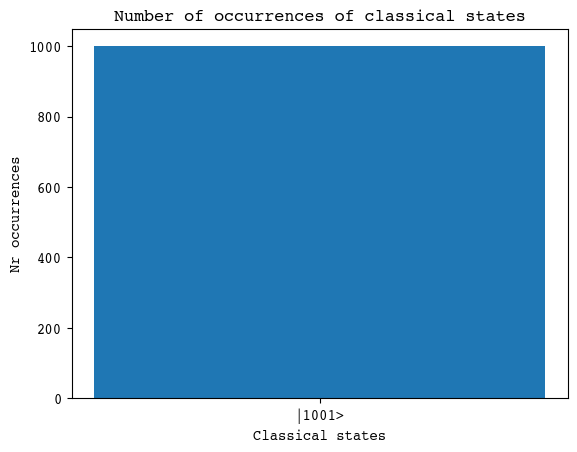

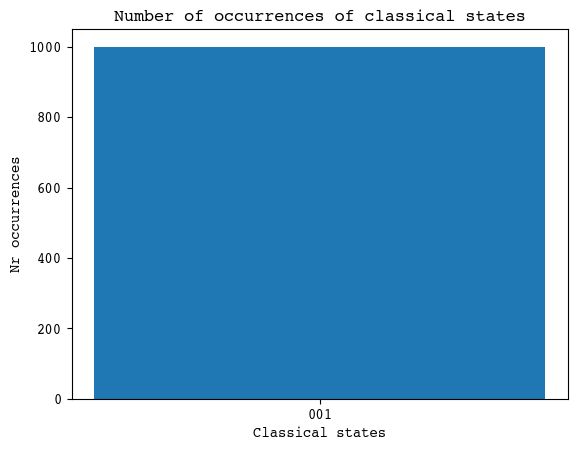

Number of counting qubits :  3
Binary value is           :  001
Integer value is          :  1
Estimated phase is        :  0.125
Actual phase is           :  0.125


In [4]:
theta = np.pi/4
quantum_phase_estimation(3, theta, 1000)

## Example: more precision with more counting qubits
In this example we estimate the phase of $P(\frac{2 \pi}{3})$. Hence, QPE should find $\theta = \frac{1}{3}$. We show that adding more counting qubits (thus increasing $t$) leads to a more precise estimation of the phase.

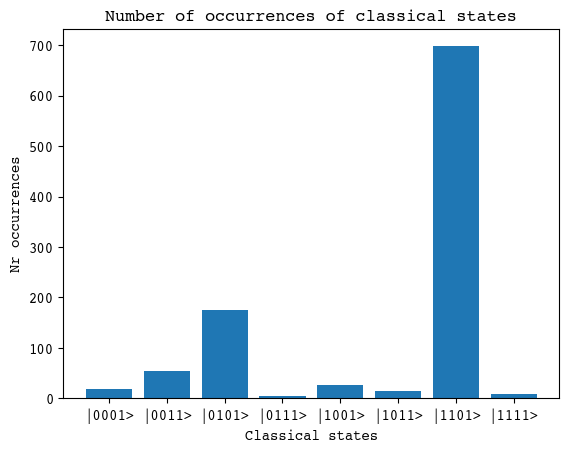

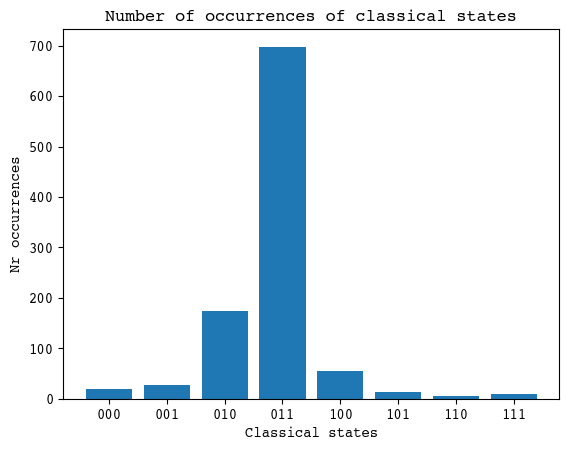

Number of counting qubits :  3
Binary value is           :  011
Integer value is          :  3
Estimated phase is        :  0.375
Actual phase is           :  0.3333333333333333


In [5]:
theta = 2*np.pi/3 
quantum_phase_estimation(3, theta, 1000)

The most common measurement is $|1101\rangle$, representing binary value $011$ and integer value $3$. The estimated phase is $3/2^3 = 3/8 = 0.375$.

The next most common measurment is $|0101\rangle$, representing binary value $010$ and integer value $2$. The estimated phase is $2/2^3 = 3/8 = 0.25$.

A more precise estimation can be found by adding more counting qubits. Below, we use $t=5$ to estimate the phase.

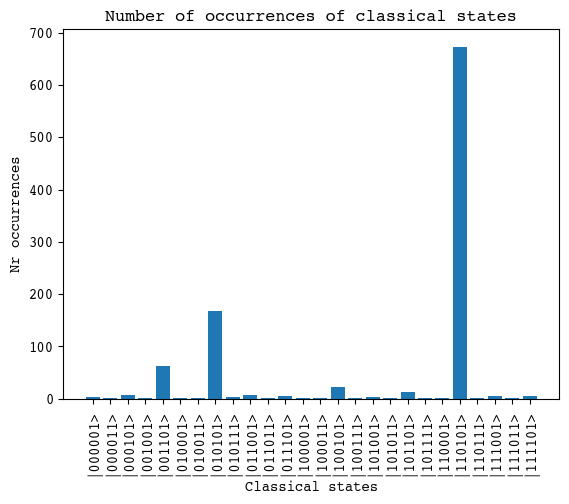

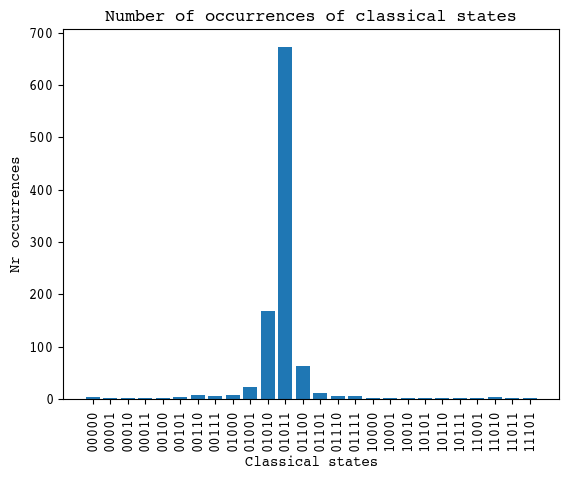

Number of counting qubits :  5
Binary value is           :  01011
Integer value is          :  11
Estimated phase is        :  0.34375
Actual phase is           :  0.3333333333333333


In [6]:
theta = 2*np.pi/3 
quantum_phase_estimation(5, theta, 1000)

The most common measurement is $|110101\rangle$, representing binary value $01011$ and integer value $11$. The estimated phase is $11/2^5 = 11/32 = 0.34375$.

The next most common measurment is $|010101\rangle$, representing binary value $01010$ and integer value $10$. The estimated phase is $10/2^5 = 10/32 = 0.3125$.

Both values are closer to the expected value $0.33$. Below, we find an even more precise estimation with $t=7$.

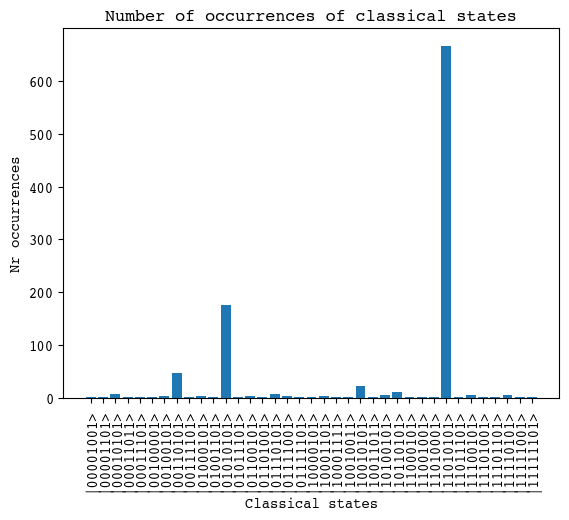

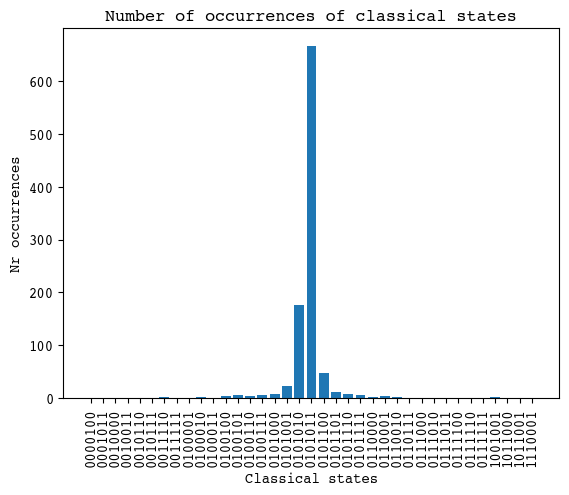

Number of counting qubits :  7
Binary value is           :  0101011
Integer value is          :  43
Estimated phase is        :  0.3359375
Actual phase is           :  0.3333333333333333


In [7]:
theta = 2*np.pi/3 
quantum_phase_estimation(7,theta,1000)

The most common measurement is $|11010101\rangle$, representing binary value $0101011$ and integer value $43$. The estimated phase is $43/2^7 = 43/128 = 0.3359375$.

The next most common measurment is $|01010101\rangle$, representing binary value $0101010$ and integer value $42$. The estimated phase is $42/2^7 = 42/128 = 0.328125$.

Again, both values are closer to the expected value $0.33$.